## Answering business questions using SQL

### 1. Introduction and Schema Diagram
In this project, we're going to use our SQL skills to answer business questions.We'll be working with a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Like with our Factbook database, a schema diagram will help us understand the available columns and the structure of the data. Here's a schema diagram for the Chinook database:
![Chinook-schema](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)

Looking at all those tables can be overwhelming at first, but generally speaking we will only need to think about the specific tables that have the data we require and their connections. Before we look at some specific tables, let's take a moment to understand the different parts of the schema diagram.

- Tables names are shown in bold, with the columns in each table listed below.
- Each table has one or more columns with shading, which indicates those columns are a **primary key**. We'll learn more about primary keys in a later mission, but for now all you need to know is that each row's primary key must be unique.
- Relationships between tables are shown using lines between the tables. The lines indicate which columns are related. You may notice that at least one 'end' of the relationship will be a primary key.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

### 2. Overview of the data

First, let's start by getting familiar with our data.

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [3]:
%%sql 
SELECT *
  FROM album
 LIMIT 3;

 * sqlite:///chinook.db
Done.


album_id,title,artist_id
1,For Those About To Rock We Salute You,1
2,Balls to the Wall,2
3,Restless and Wild,2


### 3. Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we need to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name	|Genre      |
|:--------------|:-----------|
|Regal	        |Hip-Hop    |
|Red Tone	    |Punk       |
|Meteor and the Girls|	Pop |
|Slim Jim Bites	|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.The findings will be used to make a recommendation for the three artists whose albums we should purchase for the store.


In [4]:
%%sql
WITH usa_tracks_sold AS
     (
     SELECT c.country country,
            il.track_id track_id,
            il.quantity quantity
      FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
     WHERE c.country = 'USA'
     )      

SELECT 
       g.name genre,
       SUM(uts.quantity) sales_quantity,
       ROUND(SUM(uts.quantity)/(
                              SELECT CAST(SUM(quantity) AS FLOAT)
                                FROM usa_tracks_sold
                             )*100, 2)||'%' sales_percentage       
 FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN usa_tracks_sold uts ON uts.track_id = t.track_id
GROUP BY 1
ORDER BY 2 DESC;
        

 * sqlite:///chinook.db
Done.


genre,sales_quantity,sales_percentage
Rock,561,53.38%
Alternative & Punk,130,12.37%
Metal,124,11.8%
R&B/Soul,53,5.04%
Blues,36,3.43%
Alternative,35,3.33%
Latin,22,2.09%
Pop,22,2.09%
Hip Hop/Rap,20,1.9%
Jazz,14,1.33%


According to the sales records of different genres in the USA, we should purchase albums from the following three artists:

|Artist Name	|Genre      |
|:--------------|:-----------|
|Red Tone	    |Punk       |
|Slim Jim Bites	|Blues|
|Meteor and the Girls|	Pop |

### 4. Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We want to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
%%sql
DROP VIEW employee_info;
CREATE VIEW employee_info AS
        SELECT e.first_name||' '||e.last_name employee_name,
               e.hire_date,          
               i.invoice_date invoice_date,
               i.total total               
         FROM employee e
        INNER JOIN customer c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice i ON i.customer_id = c.customer_id;
       
SELECT employee_name, 
       hire_date,
       SUM(total) total_sale
  FROM employee_info  
 GROUP BY 1; 

 * sqlite:///chinook.db
Done.
Done.
Done.


employee_name,hire_date,total_sale
Jane Peacock,2017-04-01 00:00:00,1731.5100000000039
Margaret Park,2017-05-03 00:00:00,1584.0000000000034
Steve Johnson,2017-10-17 00:00:00,1393.920000000002


At first sight, it seems there is a performance difference between sales agents. However, the sales agent with the lowest sales also tart the latest. Let's compare their sales record starting from the same date.

In [6]:
%%sql
SELECT employee_name, 
       SUM(total) total_sale
  FROM employee_info 
WHERE  invoice_date > '2017-10-17 00:00:00'
 GROUP BY 1;

 * sqlite:///chinook.db
Done.


employee_name,total_sale
Jane Peacock,1312.740000000002
Margaret Park,1196.9100000000012
Steve Johnson,1167.210000000001


By looking at the sales record during the same period, it seems there is not much difference between the performance of employees.

### 5. Analysing Sales by Country

Next, we are going to analyze the sales data for customers from each different country. In particular, we are going to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

First of all, let's explore the number of customers in each country.

In [7]:
%%sql
SELECT c.country,
       COUNT(distinct c.customer_id) customer
  FROM customer c
 INNER JOIN invoice i on i.customer_id = c.customer_id
 GROUP BY 1
 ORDER BY 2;
       

 * sqlite:///chinook.db
Done.


country,customer
Argentina,1
Australia,1
Austria,1
Belgium,1
Chile,1
Denmark,1
Finland,1
Hungary,1
Ireland,1
Italy,1


There are a number of countries with only one customer. To make our assessments more sensible, we will group these customers as **"Other"** in our analysis.

In [8]:
%%sql
DROP VIEW country_sale;
CREATE VIEW country_sale AS
WITH country_customer AS
    ( 
        SELECT  CASE
                    WHEN 
                        --# Assign the country name to 'Others' when there is only one customer in that country
                         ( 
                           SELECT COUNT(DISTINCT customer_id)
                             FROM customer c1
                            GROUP BY c1.country
                            HAVING c1.country = c.country
                          ) =  1 THEN 'Others'
                     ELSE c.country
                END AS country,
                c.customer_id customer_id,
                i.total total,
                i.invoice_id invoice_id       
          FROM customer c
         INNER JOIN invoice i ON i.customer_id = c.customer_id
    )      

SELECT country,
       customer_num,
       ROUND(total_sales, 2) total_sales,
       ROUND(total_sales/customer_num, 2) avg_per_customer,
       ROUND(total_sales/order_num, 2) avg_per_order        
 FROM 
        ( SELECT
                 country,
                 COUNT(DISTINCT customer_id) customer_num,
                 SUM(total) total_sales,
                 COUNT(DISTINCT invoice_id) order_num,
                 CASE
                     WHEN country = 'Others' THEN 1
                     ELSE 0
                  END AS sort                         
           FROM country_customer
          GROUP BY 1
        )
ORDER BY sort ASC, total_sales DESC, avg_per_customer DESC, avg_per_order DESC;

SELECT *
  FROM country_sale

 * sqlite:///chinook.db
Done.
Done.
Done.


country,customer_num,total_sales,avg_per_customer,avg_per_order
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Others,15,1094.94,73.0,7.45


To make it easier to see the results, we will plot the data in charts. First of all, we will have a look at the spread of customers and sales in different countries and see if they have similar trends.

In [9]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Read SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query('''SELECT * FROM country_sale''', conn)


#Visualize with pie chart
labels = df['country']
sizes = np.array(df['customer_num'])
sales = np.array(df['total_sales'])
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
fig, ax = plt.subplots(figsize=(8, 8))
size = 0.3

ax.pie(sizes, labels=labels, startangle=90, radius=1, autopct='%1.1f%%',pctdistance=0.88, 
       wedgeprops=dict(width=size, edgecolor='w'), explode = explode)
ax.pie(sales, startangle=90, radius=1-size, autopct='%1.1f%%',pctdistance=0.8,
       wedgeprops=dict(width=size, edgecolor='w'))

## Add tag for Customer spread
ax.text(-1.7, 0.6, 'Customer Spread', style='italic', fontsize = 12, 
        bbox={'facecolor':'red', 'alpha':0.3, 'pad':12})  

## Add tag for Sales spread
ax.text(0.5, 0.5,'Sales Spread', style='italic', fontsize = 12, horizontalalignment='center', 
      verticalalignment='center',transform=ax.transAxes, 
      bbox={'facecolor':'green', 'alpha':0.3, 'pad':12})

ax.set_title("Customer and Sales Spread Around The World", fontsize = 15)
plt.show()



<Figure size 800x800 with 1 Axes>

**USA, Canada and Brazil** have the three highest customer share and sales share around the world, indicating that the markets in these countries are relatively mature. However, countries with more customers do not neccesarrily have the same percentage of sales. For example, Canada has 13.6% customers share but only 11.4% sales share. This may be caused by the fact that different customer spend different amount of money per order in different countries. Let's use bar charts to visualise the average value of sales per customer and average order value in different countries to get a better idea.

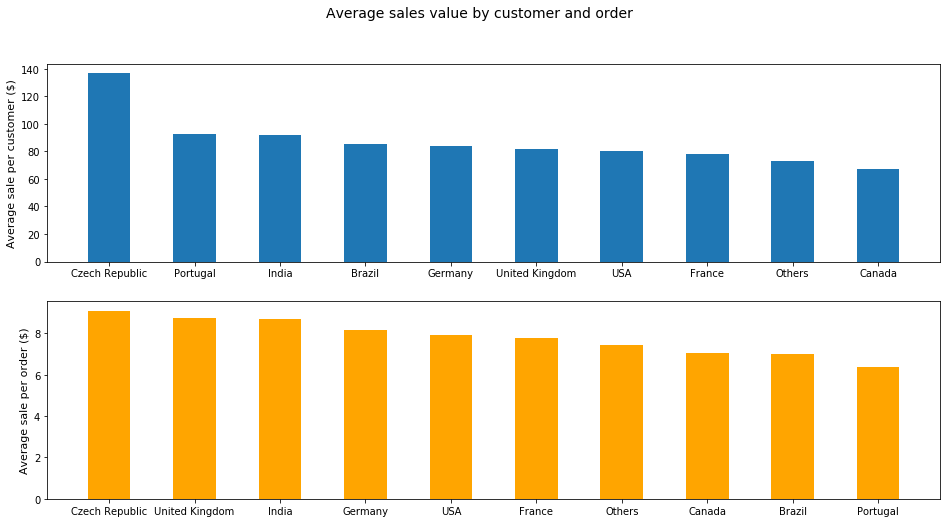

In [10]:
# Create dataframe with ordered data for plotting
average_per_customer = df[['country','avg_per_customer']].sort_values(by=['avg_per_customer'],ascending = False)
average_per_order = df[['country','avg_per_order']].sort_values(by=['avg_per_order'],ascending = False)


#Visualize average sales value with bar chart
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 8))
fig.suptitle('Average sales value by customer and order', fontsize = 14)
ax1.bar(average_per_customer['country'], average_per_customer['avg_per_customer'], width = 0.5)
ax2.bar(average_per_order['country'], average_per_order['avg_per_order'], width = 0.5, color = 'orange')

ax1.set_ylabel('Average sale per customer ($)', fontsize = 11)
ax2.set_ylabel('Average sale per order ($)', fontsize = 11)

plt.show()

- **Czech Republic and India** have high values in both average sales per customer and average sales per order. They have great potential for market expansion. 

- Both **UK and Portugal** have potential for market expansion as well. However, their customers have different purchase habbits. Customers in **Portugal** have the second highest sales value per cusomer. However, they have the lowest sales value per order, indicating that they do more frequent purchase. By contrast, **UK** has the second highest average sales value per order although their average sales per customer is not very high. This indicates that customers in the UK don't purchase music as frequent by comparison. 

The above four countries all have potential for market expansion. Different marketing strategy should be applied for different countries due to the differnce in customer shopping habits. However, the size of the data is relatively low to give us high confidence. Only small market campains are recommended at the beginning to generate more data for further analysis.

### 6. Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

First, let's have a look at the purchase type in the sales record.

In [16]:
%%sql
DROP VIEW tracks_per_album;
DROP VIEW count_of_tracks;
CREATE VIEW tracks_per_album AS
    
        SELECT DISTINCT album_id,
               COUNT(t.track_id) track_count
          FROM track t
         GROUP BY album_id;
    
CREATE VIEW count_of_tracks AS
            
        SELECT il.invoice_id, 
               t.album_id,
               COUNT(il.track_id) track_count
          FROM invoice_line il 
         INNER JOIN track t ON t.track_id = il.track_id
         GROUP BY invoice_id, album_id;
    
    
SELECT  ct.invoice_id,
        ct.album_id,
        CASE 
            WHEN
                ct.track_count = tpa.track_count THEN 'Album'
            ELSE 'Individual Tracks'
        END AS purchase_type  
  FROM count_of_tracks ct
INNER JOIN tracks_per_album tpa ON tpa.album_id = ct.album_id
LIMIT 40
        


 * sqlite:///chinook.db
Done.
Done.
Done.
Done.
Done.


invoice_id,album_id,purchase_type
1,91,Album
2,20,Individual Tracks
2,34,Individual Tracks
2,39,Individual Tracks
2,66,Individual Tracks
2,73,Individual Tracks
2,134,Individual Tracks
2,190,Individual Tracks
2,215,Individual Tracks
2,218,Individual Tracks


We noticed that some invoice consists a mixture of both individual and album purchases. Because there are many individual tracks purchased in this situation, we will count them as inividual tracks purchase type.

In [12]:
%%sql
SELECT purchase_type,
       COUNT(DISTINCT invoice_id) invoice_count,
       ROUND(COUNT(DISTINCT invoice_id) /  (
                                    SELECT CAST(COUNT(*) AS FLOAT) 
                                      FROM invoice
                                   ) *100, 2 ) || '%' AS percentage
 FROM  (
        SELECT *
          FROM (
                SELECT  ct.invoice_id,
                        CASE WHEN
                        ct.track_count = tpa.track_count THEN 'Album'
                        ELSE 'Individual Tracks'
                        END AS purchase_type  
                FROM count_of_tracks ct
                INNER JOIN tracks_per_album tpa ON tpa.album_id = ct.album_id
                ORDER BY 1,2 DESC --# order the purchase type so that purchases consisting of both individual tracks and albums are classified as indiviaul tracks purchas type using Group next.
              )
         GROUP BY 1
      ) 
 GROUP BY purchase_type        

 * sqlite:///chinook.db
Done.


purchase_type,invoice_count,percentage
Album,114,18.57%
Individual Tracks,500,81.43%


The results show that 18.57% of the sales are album purchase, and 81.43% are individual tracks purchase. Due to the high percentage of album purchase, we would recommend the company to continue purchasing whole albums.

## 7. Conclusions

In this project, we have used SQL and explored the database of a fictional digital music store - Chinook. By analysing the data, we have learnt many aspects of their business such as the popular music genre in the USA, staff performance in the music store, sales and customer distribution around the world, and customer purchase behaviour. Based on our learning, we have answered business questions for the the managment team and made recommendations for future business directions as detailed above. We belive that Chinook music store has the potential to keep expanding their business and make more profits in the future.